In [1]:
# Libraries

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from numpy.random import default_rng
#from random import random.seed,gauss

from sklearn.preprocessing import MinMaxScaler, StandardScaler

# multivariate lstm example
from numpy import array
from numpy import hstack
import torch
import torch.nn as nn
import torch.optim as optim  # Import optim module

### Parameters

In [2]:
##
## Parameters
##

# time step
dt=0.025
# units of time to warm up NVAR. need to have warmup_pts >= 1
warmup = 5.
# units of time to train for
traintime = 10.
# units of time to test for
testtime=120.
# total time to run for
maxtime = warmup+traintime+testtime
# how much of testtime to plot
plottime=20.
# Lyapunov time of the Lorenz system
lyaptime=1.104

# discrete-time versions of the times defined above
warmup_pts=round(warmup/dt)
traintime_pts=round(traintime/dt)
warmtrain_pts=warmup_pts+traintime_pts
testtime_pts=round(testtime/dt)
maxtime_pts=round(maxtime/dt)
plottime_pts=round(plottime/dt)
lyaptime_pts=round(lyaptime/dt)

# input dimension
d = 1
# number of time delay taps
k = 2
# size of linear part of feature vector
dlin = k*d
# size of nonlinear part of feature vector
dnonlin = int(dlin*(dlin+1)/2)
# total size of feature vector: constant + linear + nonlinear
dtot = 1 + dlin + dnonlin

# ridge parameter for regression
ridge_param = 1.4e-2

# t values for whole evaluation time
# (need maxtime_pts + 1 to ensure a step of dt)
t_eval=np.linspace(0,maxtime,maxtime_pts+1)

### Macky Glass

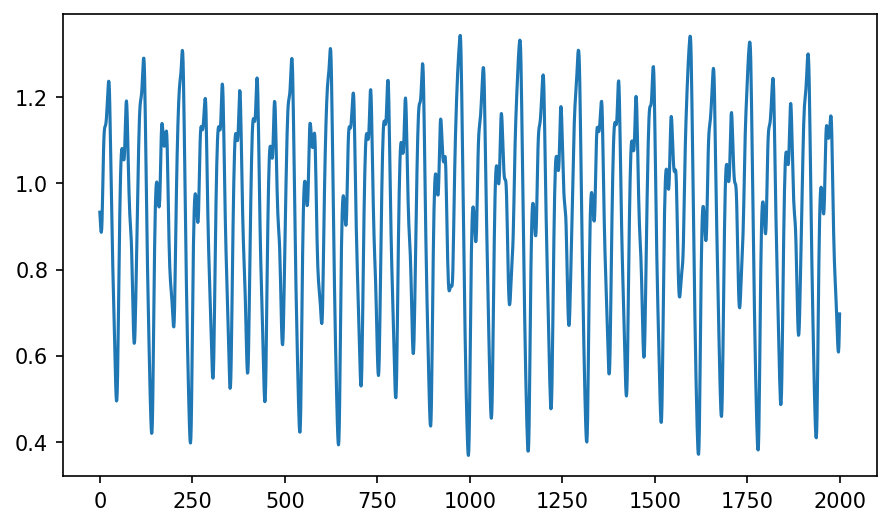

In [3]:
N  = 20000

b   = 0.1
c   = 0.2
tau = 17

y = [0.9697, 0.9699, 0.9794, 1.0003, 1.0319, 1.0703, 1.1076, 1.1352, 1.1485,
     1.1482, 1.1383, 1.1234, 1.1072, 1.0928, 1.0820, 1.0756, 1.0739, 1.0759]

for n in range(17,N+99):
    y.append(y[n] - b*y[n] + c*y[n-tau]/(1+y[n-tau]**10))
y = y[100:]


plt.figure(figsize=(7,4), dpi=150)
plt.plot(y[:2000])

In [4]:
# univariate data preparation

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
 X, y = list(), list()
 for i in range(len(sequence)):
     # find the end of this pattern
     end_ix = i + n_steps
     # check if we are beyond the sequence
     if end_ix > len(sequence)-1:
         break
     # gather input and output parts of the pattern
     seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
     X.append(seq_x)
     y.append(seq_y)
 return array(X), array(y)

# define input sequence
#raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps = 3
# split into samples
X, y = split_sequence(y, n_steps)
# summarize the data
for i in range((5)):
 print(X[i], y[i])

[0.93314296 0.91752166 0.9023854 ] 0.8908161329219243
[0.91752166 0.9023854  0.89081613] 0.8865321614762076
[0.9023854  0.89081613 0.88653216] 0.8933150662137542
[0.89081613 0.88653216 0.89331507] 0.91370260690864
[0.88653216 0.89331507 0.91370261] 0.9474710440522821


### Parameters of LSTM

In [15]:
input_size = 3
sequence_length = 15

num_layers=2
hidden_size=10

learning_rate = 0.001

output_dim = 1
batch_size = 1
num_epochs = 60

### Define LSTM

In [16]:
# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, :])
        return out

In [22]:
model = LSTMModel(input_size, hidden_size, num_layers, output_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
y_tensor = torch.tensor(y, dtype=torch.float32)
x_tensor = torch.tensor(X, dtype=torch.float32)#.reshape(-1, sequence_length, input_size)
x_tensor.to(device)
loss_criterion  = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr = learning_rate, weight_decay = 0.01, betas=(0.9, 0.999))

#x_tensor = x_tensor.reshape(-1,input_size, sequence_length)
#x_tensor.shape
print(x_tensor, x_tensor.shape)
#x_out = torch.zeros(x_tensor.shape).reshape(3,-1)
#x_out.shape
#print(model)

tensor([[0.9331, 0.9175, 0.9024],
        [0.9175, 0.9024, 0.8908],
        [0.9024, 0.8908, 0.8865],
        ...,
        [0.9686, 1.0066, 1.0354],
        [1.0066, 1.0354, 1.0552],
        [1.0354, 1.0552, 1.0664]]) torch.Size([19997, 3])


In [18]:
scaler = StandardScaler().fit(x_tensor)
x_tensor_n = scaler.transform(x_tensor)
x_tensor_n = torch.tensor(x_tensor_n, dtype=torch.float32)
#x_tensor_n = torch.tensor(x_tensor, dtype=torch.float32)

<ipython-input-27-fa3f777cbea1>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(x_tensor_n[i+1,2]-x_tensor_n[i+1,1])
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


At epoch: 0, loss: 0.03765967071252824
At epoch: 10, loss: 0.021584729490853258
At epoch: 20, loss: 0.021521736146942985
At epoch: 30, loss: 0.021517909372704907
At epoch: 40, loss: 0.021526637817154536
At epoch: 50, loss: 0.021529087442673216


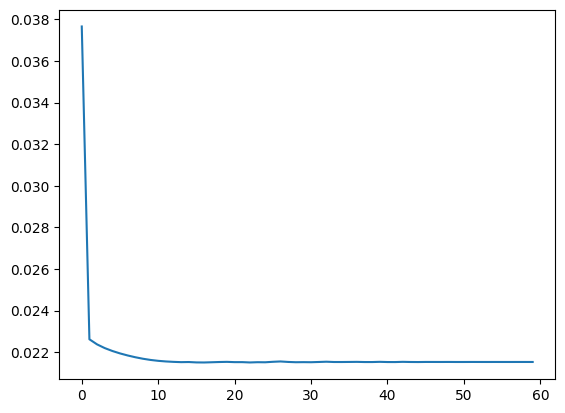

In [27]:
current_loss = 0
loss_hist = []
loss = 0
model.train()

for epoch in range(num_epochs):
    for i in range(traintime_pts - 1):
        #index = i + warmup_pts -1
        target = torch.tensor(x_tensor_n[i+1,2]-x_tensor_n[i+1,1])
        data = x_tensor_n[i,:].reshape(1,3)
        data = data.to(device)
        #data = torch.transpose(data, 0, 1)
        target = target.to(device)
        outputs = model(data)
        loss = loss_criterion(outputs,target)
        current_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (epoch % 10 == 0):
        print(f"At epoch: {epoch}, loss: {current_loss/traintime_pts}")
    loss_hist.append(current_loss/traintime_pts)
    current_loss = 0

plt.plot(loss_hist)
plt.show()

# calculate NRMSE between true Lorenz and training output
#rms = np.sqrt(np.mean((x[0:d,warmup_pts:warmtrain_pts]-x_predict[:,:])**2)/total_var)
#print('training nrmse: '+str(rms))

In [29]:
def evaluate():
    model.eval()
    total_acc, total_count = 0, 0
    predicted = torch.zeros(dlin,testtime_pts).to(device)
    predicted[0:sequence_length+1] = x_tensor_n[:,warmtrain_pts:warmtrain_pts+sequence_length+1]
    with torch.no_grad():
        for i in range(testtime_pts-sequence_length-1):
          xin = predicted[i:i+sequence_length]
          output = model(torch.transpose(xin, 0, 1))
          predicted[d:dlin,i+sequence_length+1] = predicted[0:d,i+sequence_length]
          predicted[0:d,i+sequence_length+1] = output[sequence_length-1,:] + predicted[d:dlin,i+sequence_length+1]
          #loss = loss_criterion(predicted[:,i], x_tensor[:,testtime_pts+i])
          total_acc += loss
          #total_count += label.size(0)
    return predicted

xin = torch.zeros(dlin,sequence_length).to(device)
pred = evaluate()

MSE = loss_criterion(x_tensor_n[0:d,warmtrain_pts-1:warmtrain_pts+lyaptime_pts-1].cpu(), pred[0:d,0:lyaptime_pts].cpu())

print(MSE)

#MSE = loss_criterion(x_tensor[0:d,warmtrain_pts-1:warmtrain_pts+lyaptime_pts-1].cpu(), torch.tensor(x_test[0:d,0:lyaptime_pts]))

#print(MSE)

# calculate MSE between true Lorenz and prediction for one Lyapunov time
#test_nrmse = np.sqrt(np.mean((x_tensor[0:d,warmtrain_pts-1:warmtrain_pts+lyaptime_pts-1].cpu().detach().numpy()-pred[0:d,0:lyaptime_pts].cpu().detach().numpy()**2)/total_var))
#print('test nrmse: '+str(test_nrmse))

RuntimeError: The expanded size of the tensor (4800) must match the existing size (0) at non-singleton dimension 1.  Target sizes: [2, 4800].  Tensor sizes: [19997, 0]

In [ ]:
print(x_tensor_n, x_tensor_n.shape)

tensor([[ 0.0329, -0.0334, -0.0976],
        [-0.0334, -0.0976, -0.1466],
        [-0.0975, -0.1466, -0.1648],
        ...,
        [ 0.1832,  0.3442,  0.4664],
        [ 0.3442,  0.4665,  0.5504],
        [ 0.4665,  0.5504,  0.5978]]) torch.Size([19997, 3])


In [ ]:
# Define hyperparameters
input_size = 3  # Specify the input size
hidden_size = 20 # Specify the hidden size
num_layers = 2 # Specify the number of LSTM layers
output_dim = 1 # Specify the output dimension
learning_rate = 0.001 # Specify the learning rate
num_epochs = 30 # Specify the number of epochs

In [ ]:
x_tensor = torch.tensor(X, dtype=torch.float32).to(device)


# Initialize the LSTM model
model = LSTMModel(input_size, hidden_size, num_layers, output_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss criterion and optimizer
loss_criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01, betas=(0.9, 0.999))

# Training loop
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = model(x_tensor)

    # Compute the loss
    loss = loss_criterion(outputs, y)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

TypeError: 'int' object is not callable

In [ ]:
# Testing the model
model.eval()
with torch.no_grad():
    predicted_output = model(x_test_tensor)  # Assuming you have a tensor for test data

# You can now use the predicted_output for further analysis or evaluation